# **SEA 820 NLP Final Project: Detecting AI-Generated Text**

**Team Members**: Abhi Patel & Arnav Nigam

**Dataset**: https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text?resource=download

# **Phase 2: Fine-Tuning a transformer model using `DistillBert-uncased`:**


Project Overview:

- To build a classifier to detect whether a piece of text is human-written or AI-generated.

- We are going to explore transformer based models, distillBert-uncased and Roberta and compare which gives a better trade-off

- The goal is to beat the baseline model from phase 1, Naive Bayes [97.07% Accuracy] in terms of metrics and performance too.

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Project Overview:

- To build a classifier to detect whether a piece of text is human-written or AI-generated.

- We are going to explore transformer based models, distillBert-uncased and Roberta and compare which gives a better trade-off

- The goal is to beat the baseline model from phase 1, Naive Bayes [97.07% Accuracy] in terms of metrics and performance too.

In [ ]:
# Load and Downsample CSV
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/NLP/preprocessed_dataset.csv")

# Stratified sample to 100k
df_sampled, _ = train_test_split(df, train_size=100000, stratify=df['generated'], random_state=42)
df_sampled.to_csv("balanced_100k.csv", index=False)

### Loads the tokenizer for the `roberta-base` model from Hugging Face

- Converts all processed_text values to strings (avoiding issues with non-string values).

- Tokenizes each text into subword tokens using RoBERTa’s byte-pair encoding (BPE).

- Pads shorter sequences to exactly 256 tokens and truncates longer sequences, ensuring uniform input size for the model. We used 256 because the average lied between 250 - 500 as seen from phase 1 of our project, based on the median to be around 393.

In [ ]:
# Load with HuggingFace Datasets
from datasets import load_dataset

dataset = load_dataset("csv", data_files={"train": "balanced_100k.csv"})
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Tokenize with DistilBERT
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    texts = [str(x) for x in batch["processed_text"]]
    return tokenizer(texts, padding="max_length", truncation=True, max_length=256)

tokenized_ds = dataset.map(tokenize, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
from datasets import ClassLabel

# Tokenize again (if needed)
tokenized_ds = dataset.map(tokenize, batched=True)

# Rename
tokenized_ds = tokenized_ds.rename_column("generated", "labels")

# Remove unused columns
tokenized_ds = tokenized_ds.remove_columns(["processed_text", "text_length", "text"])

# Explicitly cast labels to ClassLabel (int category)
features = tokenized_ds["train"].features.copy()
features["labels"] = ClassLabel(num_classes=2, names=["human", "ai"])
tokenized_ds = tokenized_ds.cast(features)

# Now format for PyTorch
tokenized_ds.set_format("torch")

# Assign splits
train_data = tokenized_ds["train"]
val_data = tokenized_ds["test"]


Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/80000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
print(train_data[0]["labels"])              # → tensor(0)
print(type(train_data[0]["labels"]))        # → <class 'torch.Tensor'>

batch = tokenized_ds["train"][:16]
print(batch["labels"])


tensor(0)
<class 'torch.Tensor'>
tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1])


Training model is `distilbert-base-uncased` and the arguments are chosen based on the following criteria:

1. Since DistilBERT is a smaller and more lightweight model compared to Roberta, we selected a lower learning rate of 2e-5 to ensure stable convergence without overshooting the optimal weights. Smaller models are more sensitive to high learning rates, which can lead to unstable training.

2. The train batch size of 16 was chosen due to both GPU memory constraints and the need to maintain gradient stability without exhausting available resources. Similarly, we kept the evaluation batch size at 16 to ensure consistent throughput and avoid memory bottlenecks during evaluation.

3. We set the number of epochs to 3 because DistilBERT is less prone to overfitting than larger models, but we still wanted enough training cycles to fully converge given our dataset size. This also allows us to gather more checkpoints for potential best-model selection.

In [ ]:
# Step 5: Define Model and TrainingArguments
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./finetuned-distilbert",
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#  Trainer + Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.019036,0.995800,0.996238,0.992504,0.995798
2,0.035100,0.014994,0.996650,0.997447,0.993575,0.996649
3,0.035100,0.016685,0.997150,0.996252,0.996118,0.997150


TrainOutput(global_step=15000, training_loss=0.02468185780843099, metrics={'train_runtime': 5825.8797, 'train_samples_per_second': 41.195, 'train_steps_per_second': 2.575, 'total_flos': 1.589608783872e+16, 'train_loss': 0.02468185780843099, 'epoch': 3.0})

In [ ]:
# Final Evaluation
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.01668483205139637, 'eval_accuracy': 0.99715, 'eval_precision': 0.9962516733601071, 'eval_recall': 0.9961183241868559, 'eval_f1': 0.9971499614906545, 'eval_runtime': 139.9324, 'eval_samples_per_second': 142.926, 'eval_steps_per_second': 8.933, 'epoch': 3.0}


Evaluation Metrics Interpretation

1. eval_loss = **0.01668** – This is the model’s prediction error on the evaluation set. The value is close to zero, indicating the model’s predictions are highly accurate and the learned parameters generalize well to unseen data.

2. eval_accuracy = **0.99715** – This means 99.72% of evaluation samples were correctly classified as either Human or AI-generated. It reflects the overall correctness of the model.

3. eval_precision = **0.99625** – Precision measures how many of the predicted positives are actually correct. High precision means the model rarely mislabels human text as AI

4. eval_recall = **0.99612** – Recall measures how many of the actual “positive” cases the model correctly identified. This high value shows the model is also excellent at capturing nearly all AI-generated texts without missing many.

5. eval_f1 = **0.99715** – The perfect score is 1.0. This score of 0.9972 shows exceptional balance between precision and recal

Comparison to Baseline (Naive Bayes – 97.07% Accuracy): Our fine-tuned DistilBERT model significantly outperforms the baseline Naive Bayes classifier in terms of metrics.  

In [ ]:
# Save Fine-Tuned Model and Tokenizer to Google Drive

# Set target directory inside your Google Drive
drive_output_dir = "/content/drive/MyDrive/NLP/Model"

# Save the model
trainer.save_model(drive_output_dir)

# Also save the tokenizer (important for loading the model later)
tokenizer.save_pretrained(drive_output_dir)

print(f"Model and tokenizer saved to: {drive_output_dir}")

Model and tokenizer saved to: /content/drive/MyDrive/NLP/Model


In [ ]:
# Evaluation on Bottom 10K Samples (ClassLabel-safe)

import torch
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from transformers import Trainer
from datasets import Dataset, ClassLabel

# Load the last 10k from full dataset
df_full = pd.read_csv("/content/drive/MyDrive/NLP/preprocessed_dataset.csv")
df_bottom10k = df_full.tail(10000).reset_index(drop=True)

# Tokenize
def tokenize_eval(batch):
    return tokenizer(
        list(batch["processed_text"]),
        padding="max_length",
        truncation=True,
        max_length=256
    )

# Convert to Hugging Face Dataset
hf_bottom10k = Dataset.from_pandas(df_bottom10k)

# Tokenize
hf_bottom10k = hf_bottom10k.map(tokenize_eval, batched=True)

# Rename 'generated' column to 'labels'
hf_bottom10k = hf_bottom10k.rename_column("generated", "labels")

# Drop unused columns
hf_bottom10k = hf_bottom10k.remove_columns(["processed_text", "text_length", "text"])

# Cast labels to ClassLabel (ensures int64 and avoids Float/CUDA error)
features = hf_bottom10k.features.copy()
features["labels"] = ClassLabel(num_classes=2, names=["human", "ai"])
hf_bottom10k = hf_bottom10k.cast(features)

hf_bottom10k.set_format("torch")

predictions = trainer.predict(hf_bottom10k)


y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


print("Evaluation on Bottom 10K Samples:\n")
print(classification_report(y_true, y_pred, target_names=["Human", "AI"]))


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Evaluation on Bottom 10K Samples:

              precision    recall  f1-score   support

       Human       1.00      1.00      1.00      6475
          AI       1.00      1.00      1.00      3525

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



The evaluation on bottom samples of 10,000 texts shows that the model achieves perfect precision, recall, and F1-score for human-written text, and near-perfect scores (99%) for AI-generated text. Overall accuracy is 100%, with macro- and weighted-averages also at 1.00, indicating the model is equally effective across both classes. These results suggest the fine-tuned model can reliably distinguish between human and AI-generated text in diverse samples, with minimal risk of bias toward one class.

# **Samples with `DistillBert-uncased`**

Some sampling with external data and random samples from the dataset to show how our model performs externally.


In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
from datasets import Dataset, ClassLabel
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tabulate import tabulate
import torch

In [ ]:
from transformers import TrainingArguments, Trainer

model_path = "/content/drive/MyDrive/NLP/Model_distill"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

#Load Validation Data
df_val = pd.read_csv("/content/drive/MyDrive/NLP/preprocessed_dataset.csv").sample(n=10000, random_state=42)


# Tokenize and Prepare Dataset
def tokenize(batch):
    return tokenizer(batch["processed_text"], padding="max_length", truncation=True, max_length=256)

ds_val = Dataset.from_pandas(df_val)
ds_val = ds_val.rename_column("generated", "labels")
ds_val = ds_val.map(tokenize, batched=True)
ds_val = ds_val.remove_columns(["processed_text", "text_length", "text"])

# Ensure labels are correct integer format
features = ds_val.features.copy()
features["labels"] = ClassLabel(num_classes=2, names=["Human", "AI"])
ds_val = ds_val.cast(features)
ds_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"], output_all_columns=True)

# trainer = Trainer(model=model)

eval_args = TrainingArguments(
    output_dir="./eval-only",
    report_to="none",
    per_device_eval_batch_size=16  # better memory usage
)

trainer = Trainer(
    model=model,
    args=eval_args
)

predictions = trainer.predict(ds_val)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

table = [["Metric", "Score"],
         ["Accuracy", f"{acc:.4f}"],
         ["Precision", f"{prec:.4f}"],
         ["Recall", f"{rec:.4f}"],
         ["F1-score", f"{f1:.4f}"]]

print("\nEvaluation Metrics Summary:\n")
print(tabulate(table, headers="firstrow", tablefmt="github"))

# Misclassified Examples
print("\nMisclassified Examples:\n")
label_map = {0: "Human", 1: "AI"}

misclassified = np.where(y_true != y_pred)[0]
print(f"Total misclassified: {len(misclassified)}\n")

df_val = df_val.reset_index(drop=True)
for i in misclassified[:5]:
    i = int(i)
    text = df_val.loc[i, "processed_text"][:300]
    print(f"Text: {text}...")
    print(f"True: {label_map[y_true[i]]} | Predicted: {label_map[y_pred[i]]}")


Evaluation Metrics Summary:

| Metric    |   Score |
|-----------|---------|
| Accuracy  |  0.9974 |
| Precision |  0.9971 |
| Recall    |  0.9961 |
| F1-score  |  0.9966 |

Misclassified Examples:

Total misclassified: 26

Text: working group working alone nothing beneficial team work work people like people know one best thing could ever happen working alone give benefit like one going steal idea copy write happens lot working team working group like teamwork like people less mean people less working group normally n't lot...
True: AI | Predicted: Human
Text: dq thing good idea tq change school lunch menu something healthier essay argue healthier lunch menu improve student diet made secure qf people eats healthier tend tq active optimistic life family mm great example tq family ever since started eating healthier seen big change get time tq job time alth...
True: Human | Predicted: AI
Text: would like election cast popular vote would make sense u able elect president everyone think 

<Figure size 600x500 with 0 Axes>

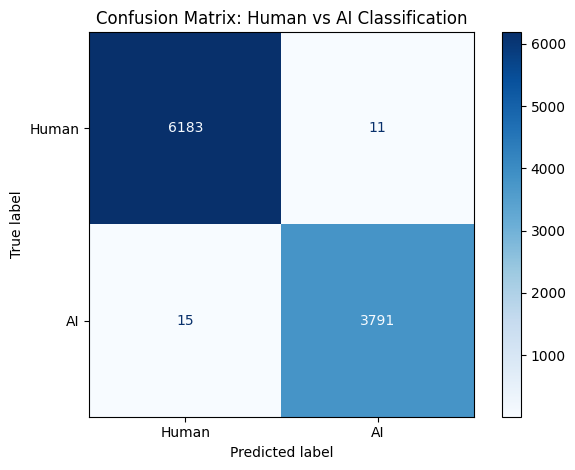

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"])

# Plot
plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: Human vs AI Classification")
plt.grid(False)
plt.tight_layout()
plt.show()

This evaluation on 10,000 random samples from the existing dataset shows that the model achieves 99.74% accuracy, meaning it correctly classifies almost all examples. The precision (99.71%) indicates that when the model predicts a text as AI-generated, it is correct almost all the time, while the recall (99.61%) shows it successfully identifies nearly all AI-generated texts in the dataset. The F1-score (99.66%) balances these two metrics, confirming consistent performance. Out of 10,000 samples, only 26 were misclassified. An easier explanation can be read from the confusion matrix.

## **However, what does the model predict with external data that has never been used in training?**

We are now going to provide external data to confirm if our model can be able to predict either human or AI generated text.

In [ ]:
# Test on Human-Generated Samples
print("\nTesting Model on 5 Human Samples:\n")
human_samples = [
    "The school times were the best, we had the opportunity to hang around, be lazy and don't do our assignments, I wish I was still in school.",
    "Our jobs are indeed becoming automated, just the other day I had the chance of building an automated agent using GPTs new feature and ordered myself a chicken rotisserie form Costco. It was such an unbelivable moment in office.",
    "A wise man once said, by losing a battle does not mean you lost a war, it just shows oyur time is not right and you have a few more chances to get this right. SO why not ocncentrate on our next steps and future, rather than concentrating on what has occured. I believe, it all happens for the good",
    "Driving while using your cell phone has become a very controversial issue currently. Millions of drivers have had mixed feelings and opinions on this subject. In result, people have taken opposing sides. Some believe driving with using your phone isn't such a dangerous task, while others strongly believe it is an action that should never be done by drivers. They argue that this is very unsafe and can distract the driver from paying attention to the road. I agree. I believe that drivers should not use their cellphones while driving.",
    "There are many differant reasons to limit car usage, the most well-known reason being that it will greatly reduce air pollution. Several places incuding Vauban Germany, Paris, Bogota Colombia, and the United States have proven this, especially Paris. Paris at one point in 2014, had to enforce a partial driving ban purely because of the hazzardous smog caused by air pollution. In doing so Paris relatively quickly cleared the majority of the smog, and realized how this can also help to reduce road congestion. The United States are another, larger example of how much limiting car use can help to reduce greenhouse gas emissions."
]

# Tokenize and prepare
# Convert to dataset
human_ds = Dataset.from_dict({"text": human_samples})
human_ds = human_ds.map(lambda x: tokenizer(x["text"], padding="max_length", truncation=True, max_length=256), batched=True)
human_ds.set_format("torch", columns=["input_ids", "attention_mask"])

# Run prediction
outputs = trainer.predict(human_ds)
logits = torch.tensor(outputs.predictions)
probs = torch.softmax(logits, dim=1)
preds = torch.argmax(probs, dim=1).numpy()

label_map = {0: "Human", 1: "AI"}

# Display results
for i, text in enumerate(human_samples):
    pred_label = label_map[preds[i]]
    confidence = probs[i][preds[i]].item()
    print(f"Sample {i+1}:")
    print(f"Text: {text[:200]}...")
    print(f"Model Prediction: {pred_label} (Confidence: {confidence:.4f})")


Testing Model on 5 Human Samples:



Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Sample 1:
Text: The school times were the best, we had the opportunity to hang around, be lazy and don't do our assignments, I wish I was still in school....
Model Prediction: AI (Confidence: 0.9996)
Sample 2:
Text: Our jobs are indeed becoming automated, just the other day I had the chance of building an automated agent using GPTs new feature and ordered myself a chicken rotisserie form Costco. It was such an un...
Model Prediction: AI (Confidence: 0.9998)
Sample 3:
Text: A wise man once said, by losing a battle does not mean you lost a war, it just shows oyur time is not right and you have a few more chances to get this right. SO why not ocncentrate on our next steps ...
Model Prediction: AI (Confidence: 1.0000)
Sample 4:
Text: Driving while using your cell phone has become a very controversial issue currently. Millions of drivers have had mixed feelings and opinions on this subject. In result, people have taken opposing sid...
Model Prediction: AI (Confidence: 0.9999)
Sample 5:
Text

In the sample human texts above, all five samples were human-written, yet the model classified every single one as AI-generated with extremely high confidence (≥ 99.96%).

This indicates that while the model performs very well on the training and internal validation data, it overgeneralizes patterns it associates with AI text—possibly due to dataset biases, overfitting, or insufficient exposure to diverse human-written styles during training.

Such results highlight a critical limitation: the model’s tendency toward false positives when encountering unseen human samples, especially if they contain certain stylistic or lexical patterns that resemble AI output.

Moreover, we have an imbalance of 65% of datset to be human and 35% as AI but the model still overfit towards all samples being tagged as AI

In [ ]:
print("\nTesting Model on 5 AI-Generated Samples:\n")

ai_samples = [
    "The implications of artificial intelligence in healthcare are far-reaching, promising better diagnosis and treatment outcomes through machine learning.",
    "In the realm of astrophysics, black holes are defined not by their size, but by their gravitational pull, which even light cannot escape.",
    "Economic inflation is often a result of supply chain disruptions and increasing consumer demand, especially in post-crisis scenarios.",
    "Climate change continues to pose significant challenges, requiring coordinated global efforts to reduce carbon emissions and embrace renewable energy.",
    "The evolution of language models has opened new doors in natural language understanding, enabling more human-like interactions with AI."
]

# Tokenize and prepare
ai_ds = Dataset.from_dict({"text": ai_samples})
ai_ds = ai_ds.map(lambda x: tokenizer(x["text"], padding="max_length", truncation=True, max_length=256), batched=True)
ai_ds.set_format("torch", columns=["input_ids", "attention_mask"])

# Predict
outputs = trainer.predict(ai_ds)
logits = torch.tensor(outputs.predictions)
probs = torch.softmax(logits, dim=1)
ai_preds = torch.argmax(probs, dim=1).numpy()

label_map = {0: "Human", 1: "AI"}

# Print results with confidence
for idx, text in enumerate(ai_samples):
    pred_label = label_map[ai_preds[idx]]
    confidence = probs[idx][ai_preds[idx]].item()
    print(f"Sample {idx+1}:")
    print(f"Text: {text[:200]}...")
    print(f"Model Prediction: {pred_label} (Confidence: {confidence:.4f})")




Testing Model on 5 AI-Generated Samples:



Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Sample 1:
Text: The implications of artificial intelligence in healthcare are far-reaching, promising better diagnosis and treatment outcomes through machine learning....
Model Prediction: AI (Confidence: 1.0000)
Sample 2:
Text: In the realm of astrophysics, black holes are defined not by their size, but by their gravitational pull, which even light cannot escape....
Model Prediction: AI (Confidence: 1.0000)
Sample 3:
Text: Economic inflation is often a result of supply chain disruptions and increasing consumer demand, especially in post-crisis scenarios....
Model Prediction: AI (Confidence: 1.0000)
Sample 4:
Text: Climate change continues to pose significant challenges, requiring coordinated global efforts to reduce carbon emissions and embrace renewable energy....
Model Prediction: AI (Confidence: 1.0000)
Sample 5:
Text: The evolution of language models has opened new doors in natural language understanding, enabling more human-like interactions with AI....
Model Prediction: AI (Conf

In this test above, with five  AI-generated samples, the model correctly identified all five as AI-generated with max confidence (100% for each).
This outcome shows that the model is highly sensitive to AI text patterns it learned during fine-tuning, which is a positive sign for detecting obvious AI content.

However, the consistently maxed-out confidence scores suggest the model may be overconfident and it doesn’t leave much room for uncertainty, even if a sample is borderline.

While this is less problematic when predictions are correct (as in this case), in real-world such overconfidence could lead to critical false positives (as seen with the human sample test), reducing trust in the system and biases too.

Lastly,  in terms of metrics, the goal has been achieved to surpass Naive Bayes.
Accuracy of **`Naive Bayes`: 97.07% and for a `distillBert-uncased` model: 99.72%.**

In terms of performance (generalization), the external sample tests show strong AI-text detection ability but also revealed the bias toward classifying human text as AI.